# Imports

In [1]:
%load_ext autoreload
%autoreload 2

%load_ext lab_black

In [2]:
# export
from exp.nb_02 import *
import torch.nn.functional as F
from torch import optim
from torch.utils.data import DataLoader, SequentialSampler, RandomSampler

In [3]:
plt.rcParams["image.cmap"] = "gray"

# Data

[Jump_to lesson 9 video](https://course.fast.ai/videos/?lesson=9&t=1786)

In [4]:
x_train, y_train, x_valid, y_valid = get_data()

In [5]:
n, m = x_train.shape
c = y_train.max() + 1
nh = 50

In [6]:
class Model(nn.Module):
    def __init__(self, n_in, nh, n_out):
        super().__init__()
        self.layers = [nn.Linear(n_in, nh), nn.ReLU(), nn.Linear(nh, n_out)]

    def __call__(self, x):
        for l in self.layers:
            x = l(x)
        return x

In [7]:
model = Model(m, nh, 10)
model

Model()

In [8]:
pred = model(x_train)
pred

tensor([[-0.0062,  0.1743,  0.0924,  ..., -0.2507, -0.0264, -0.0265],
        [-0.0464,  0.0184,  0.0800,  ..., -0.1175, -0.0459, -0.1311],
        [ 0.0003,  0.1353,  0.1385,  ..., -0.1348, -0.0700, -0.0981],
        ...,
        [-0.0765,  0.0486,  0.0930,  ..., -0.1407,  0.0242, -0.1253],
        [-0.0801,  0.0395,  0.0989,  ..., -0.2300, -0.0640, -0.0728],
        [-0.0699,  0.1208,  0.1135,  ..., -0.1072,  0.0347, -0.0478]],
       grad_fn=<AddmmBackward>)

# Cross entropy loss

First, we will need to compute the softmax of our activations. This is defined by:

$$\hbox{softmax(x)}_{i} = \frac{e^{x_{i}}}{e^{x_{0}} + e^{x_{1}} + \cdots + e^{x_{n-1}}}$$

or more concisely:

$$\hbox{softmax(x)}_{i} = \frac{e^{x_{i}}}{\sum_{0 \leq j \leq n-1} e^{x_{j}}}$$ 

In practice, we will need the log of the softmax when we calculate the loss. That is because the negative log likelihood expects log softmax and because working with logs is more stable than working with probabilities.

In [9]:
def log_softmax(x):
    return (x.exp() / (x.exp().sum(-1, keepdim=True))).log()

In [10]:
sm_pred = log_softmax(pred)

The cross entropy loss for some target $x$ and some prediction $p(x)$ is given by:

$$ -\sum x\, \log p(x) $$

But since our $x$s are 1-hot encoded, this can be rewritten as $-\log(p_{i})$ where i is the index of the desired target.

This can be done using numpy-style [integer array indexing](https://docs.scipy.org/doc/numpy-1.13.0/reference/arrays.indexing.html#integer-array-indexing). Note that PyTorch supports all the tricks in the advanced indexing methods discussed in that link.

In [11]:
y_train[:3]

tensor([5, 0, 4])

In [12]:
sm_pred[[0, 1, 2], [5, 0, 4]]

tensor([-2.4623, -2.2739, -2.2122], grad_fn=<IndexBackward>)

In [13]:
y_train.shape[0]

50000

In [14]:
def nll(inp, target):
    return -inp[range(target.shape[0]), target].mean()

In [15]:
loss = nll(sm_pred, y_train)

In [16]:
loss

tensor(2.2950, grad_fn=<NegBackward>)

Note that the formula 

$$\log \left ( \frac{a}{b} \right ) = \log(a) - \log(b)$$ 

gives a simplification when we compute the log softmax, which was previously defined as `(x.exp()/(x.exp().sum(-1,keepdim=True))).log()`

In [17]:
def log_softmax(x):
    return x - x.exp().sum(-1, keepdim=True).log()

In [18]:
test_near(nll(log_softmax(pred), y_train), loss)

Then, there is a way to compute the log of the sum of exponentials in a more stable way, called the [LogSumExp trick](https://en.wikipedia.org/wiki/LogSumExp). The idea is to use the following formula:

$$\log \left ( \sum_{j=1}^{n} e^{x_{j}} \right ) = \log \left ( e^{a} \sum_{j=1}^{n} e^{x_{j}-a} \right ) = a + \log \left ( \sum_{j=1}^{n} e^{x_{j}-a} \right )$$

where a is the maximum of the $x_{j}$.

In [20]:
torch.randint(high=100, size=(10, 4)).max(-1)

torch.return_types.max(
values=tensor([75, 77, 74, 35, 72, 92, 54, 99, 91, 98]),
indices=tensor([1, 0, 3, 1, 1, 3, 0, 3, 1, 1]))

In [21]:
def logsumexp(x):
    m = x.max(-1)[0]
    return m + (x - m[:, None]).exp().sum(-1).log()

This way, we will avoid an overflow when taking the exponential of a big activation. In PyTorch, this is already implemented for us. 

In [22]:
test_near(logsumexp(pred), pred.logsumexp(-1))

So we can use it for our `log_softmax` function.

In [23]:
def log_softmax(x):
    return x - x.logsumexp(-1, keepdim=True)

In [24]:
test_near(nll(log_softmax(pred), y_train), loss)

Then use PyTorch's implementation.

In [25]:
test_near(F.nll_loss(F.log_softmax(pred, -1), y_train), loss)

In PyTorch, `F.log_softmax` and `F.nll_loss` are combined in one optimized function, `F.cross_entropy`.

In [26]:
test_near(F.cross_entropy(pred, y_train), loss)

# Basic training loop

Basically the training loop repeats over the following steps:
- get the output of the model on a batch of inputs
- compare the output to the labels we have and compute a loss
- calculate the gradients of the loss with respect to every parameter of the model
- update said parameters with those gradients to make them a little bit better

In [27]:
loss_func = F.cross_entropy

__In PyTorch, we can't take the mean of ints, we can only do it for floats.__

In [28]:
# export
def accuracy(out, yb):
    return (torch.argmax(out, dim=1) == yb).float().mean()

In [29]:
bs = 64  # batch size

In [30]:
xb = x_train[0:bs]  # a mini-batch from x
preds = model(xb)  # predictions
preds[0], preds.shape

(tensor([-0.0062,  0.1743,  0.0924, -0.1397, -0.0934, -0.2139, -0.1310, -0.2507,
         -0.0264, -0.0265], grad_fn=<SelectBackward>),
 torch.Size([64, 10]))

In [31]:
yb = y_train[0:bs]
loss_func(preds, yb)

tensor(2.3076, grad_fn=<NllLossBackward>)

In [32]:
accuracy(preds, yb)

tensor(0.0938)

In [33]:
lr = 0.5  # learning rate
epochs = 1  # how many epochs to train for

In [39]:
for epoch in range(epochs):
    for i in range((n - 1) // bs + 1):
        #         set_trace()

        # Forward pass
        start_i = i * bs
        end_i = start_i + bs
        xb = x_train[start_i:end_i]
        yb = y_train[start_i:end_i]
        loss = loss_func(model(xb), yb)

        # Backward pass
        loss.backward()
        with torch.no_grad():
            for l in model.layers:
                if hasattr(
                    l, "weight"
                ):  # Layers that don't have learnable parameters won't have `weights` attribute
                    # Update parameters
                    l.weight -= l.weight.grad * lr
                    l.bias -= l.bias.grad * lr

                    # Zero gradients
                    l.weight.grad.zero_()
                    l.bias.grad.zero_()

In [40]:
loss_func(model(xb), yb), accuracy(model(xb), yb)

(tensor(0.0116, grad_fn=<NllLossBackward>), tensor(1.))

# Using parameters and optim

### Parameters

Use `nn.Module.__setattr__` and move relu to functional:

The reason why we use `super().__init__()` in PyTorch is that it will use the **\____setattr\____** from nn.Module that will create attributes for all our layers/functions.

In [41]:
class Model(nn.Module):
    def __init__(self, n_in, nh, n_out):
        super().__init__()
        self.l1 = nn.Linear(n_in, nh)
        self.l2 = nn.Linear(nh, n_out)

    def __call__(self, x):
        return self.l2(F.relu(self.l1(x)))

In [42]:
model = Model(m, nh, 10)

In [43]:
for name, l in model.named_children():
    print(f"{name}: {l}")

l1: Linear(in_features=784, out_features=50, bias=True)
l2: Linear(in_features=50, out_features=10, bias=True)


In [44]:
model

Model(
  (l1): Linear(in_features=784, out_features=50, bias=True)
  (l2): Linear(in_features=50, out_features=10, bias=True)
)

In [45]:
model.l1

Linear(in_features=784, out_features=50, bias=True)

In [46]:
len(list(model.parameters()))

4

In [47]:
[p.numel() for p in model.parameters()]

[39200, 50, 500, 10]

In [48]:
784 * 50, 50, 50 * 10, 10

(39200, 50, 500, 10)

In [49]:
def fit():
    for epoch in range(epochs):
        for i in range((n - 1) // bs + 1):
            start_i = i * bs
            end_i = start_i + bs
            xb = x_train[start_i:end_i]
            yb = y_train[start_i:end_i]
            loss = loss_func(model(xb), yb)

            loss.backward()
            with torch.no_grad():
                for p in model.parameters():
                    p -= p.grad * lr
                model.zero_grad()

In [53]:
list(model.parameters())[0]

Parameter containing:
tensor([[-0.0061, -0.0128,  0.0211,  ..., -0.0046,  0.0298,  0.0053],
        [ 0.0099, -0.0355,  0.0148,  ...,  0.0017, -0.0125,  0.0134],
        [-0.0112, -0.0113, -0.0162,  ...,  0.0054, -0.0312,  0.0091],
        ...,
        [-0.0142, -0.0152,  0.0066,  ..., -0.0240,  0.0048,  0.0164],
        [ 0.0349, -0.0197,  0.0311,  ..., -0.0095,  0.0355,  0.0133],
        [-0.0167,  0.0195,  0.0086,  ..., -0.0289,  0.0217, -0.0032]],
       requires_grad=True)

In [54]:
fit()
loss_func(model(xb), yb), accuracy(model(xb), yb)

(tensor(0.0795, grad_fn=<NllLossBackward>), tensor(1.))

Behind the scenes, PyTorch overrides the `__setattr__` function in `nn.Module` so that the submodules you define are properly registered as parameters of the model.

In [55]:
class DummyModule:
    def __init__(self, n_in, nh, n_out):
        self._modules = {}
        self.l1 = nn.Linear(n_in, nh)
        self.l2 = nn.Linear(nh, n_out)

    def __setattr__(self, k, v):
        # To avoid stuck in recursive loop since modules
        # start with "_" and Python internals stuff mostly
        # start with "_" as well
        if not k.startswith("_"):
            self._modules[k] = v
        super().__setattr__(k, v)

    def __repr__(self):
        return f"{self._modules}"

    def parameters(self):
        for l in self._modules.values():
            for p in l.parameters():
                yield p

In [56]:
mdl = DummyModule(m, nh, 10)
mdl

{'l1': Linear(in_features=784, out_features=50, bias=True), 'l2': Linear(in_features=50, out_features=10, bias=True)}

In [57]:
mdl._modules

{'l1': Linear(in_features=784, out_features=50, bias=True),
 'l2': Linear(in_features=50, out_features=10, bias=True)}

In [58]:
[o.shape for o in mdl.parameters()]

[torch.Size([50, 784]),
 torch.Size([50]),
 torch.Size([10, 50]),
 torch.Size([10])]

### Registering modules

We can use the original `layers` approach, but we have to register the modules.

In [61]:
layers = [nn.Linear(m, nh), nn.ReLU(), nn.Linear(nh, 10)]

add_modules allow us to create layers iteratively if we defined the layers outside of `Model` class.

In [62]:
class Model(nn.Module):
    def __init__(self, layers):
        super().__init__()
        self.layers = layers
        for i, l in enumerate(self.layers):
            self.add_module(f"layer_{i}", l)

    def __call__(self, x):
        for l in self.layers:
            x = l(x)
        return x

In [63]:
model = Model(layers)

In [64]:
model

Model(
  (layer_0): Linear(in_features=784, out_features=50, bias=True)
  (layer_1): ReLU()
  (layer_2): Linear(in_features=50, out_features=10, bias=True)
)

### nn.ModuleList

`nn.ModuleList` does this for us.

Or use ModuleList instead of manually iterating over the layers list.

In [65]:
class SequentialModel(nn.Module):
    def __init__(self, layers):
        super().__init__()
        self.layers = nn.ModuleList(layers)

    def __call__(self, x):
        for l in self.layers:
            x = l(x)
        return x

In [66]:
model = SequentialModel(layers)

In [67]:
model

SequentialModel(
  (layers): ModuleList(
    (0): Linear(in_features=784, out_features=50, bias=True)
    (1): ReLU()
    (2): Linear(in_features=50, out_features=10, bias=True)
  )
)

In [68]:
fit()
loss_func(model(xb), yb), accuracy(model(xb), yb)

(tensor(0.0319, grad_fn=<NllLossBackward>), tensor(1.))

### nn.Sequential

`nn.Sequential` is a convenient class which does the same as the above:

In [69]:
model = nn.Sequential(nn.Linear(m, nh), nn.ReLU(), nn.Linear(nh, 10))

In [70]:
fit()
loss_func(model(xb), yb), accuracy(model(xb), yb)

(tensor(0.0817, grad_fn=<NllLossBackward>), tensor(1.))

In [72]:
model

Sequential(
  (0): Linear(in_features=784, out_features=50, bias=True)
  (1): ReLU()
  (2): Linear(in_features=50, out_features=10, bias=True)
)

### optim

Let's replace our previous manually coded optimization step:

```python
with torch.no_grad():
    for p in model.parameters(): 
        p -= p.grad * lr
    model.zero_grad()
```

and instead use just:

```python
opt.step()
opt.zero_grad()
```

In [74]:
class Optimizer:
    def __init__(self, params, lr=0.5):
        self.params, self.lr = list(params), lr

    def step(self):
        with torch.no_grad():
            for p in self.params:
                p -= p.grad * lr

    def zero_grad(self):
        for p in self.params:
            p.grad.data.zero_()

In [75]:
model = nn.Sequential(nn.Linear(m, nh), nn.ReLU(), nn.Linear(nh, 10))

In [76]:
opt = Optimizer(model.parameters())

In [77]:
for epoch in range(epochs):
    for i in range((n - 1) // bs + 1):
        start_i = i * bs
        end_i = start_i + bs
        xb = x_train[start_i:end_i]
        yb = y_train[start_i:end_i]
        pred = model(xb)
        loss = loss_func(pred, yb)

        loss.backward()
        opt.step()
        opt.zero_grad()

In [78]:
loss, acc = loss_func(model(xb), yb), accuracy(model(xb), yb)
loss, acc

(tensor(0.1451, grad_fn=<NllLossBackward>), tensor(0.9375))

PyTorch already provides this exact functionality in `optim.SGD` (it also handles stuff like momentum, which we'll look at later - except we'll be doing it in a more flexible way!)

In [79]:
def get_model():
    model = nn.Sequential(nn.Linear(m, nh), nn.ReLU(), nn.Linear(nh, 10))
    return model, optim.SGD(model.parameters(), lr=lr)

In [80]:
model, opt = get_model()
loss_func(model(xb), yb)

tensor(2.2828, grad_fn=<NllLossBackward>)

In [81]:
for epoch in range(epochs):
    for i in range((n - 1) // bs + 1):
        start_i = i * bs
        end_i = start_i + bs
        xb = x_train[start_i:end_i]
        yb = y_train[start_i:end_i]
        pred = model(xb)
        loss = loss_func(pred, yb)

        loss.backward()
        opt.step()
        opt.zero_grad()

In [82]:
loss, acc = loss_func(model(xb), yb), accuracy(model(xb), yb)
loss, acc

(tensor(0.0648, grad_fn=<NllLossBackward>), tensor(1.))

Randomized tests can be very useful.

# Dataset and DataLoader

### Dataset

It's clunky to iterate through minibatches of x and y values separately:

```python
    xb = x_train[start_i:end_i]
    yb = y_train[start_i:end_i]
```

Instead, let's do these two steps together, by introducing a `Dataset` class:

```python
    xb,yb = train_ds[i*bs : i*bs+bs]
```

In [83]:
# export
class Dataset:
    def __init__(self, x, y):
        self.x, self.y = x, y

    def __len__(self):
        return len(self.x)

    def __getitem__(self, i):
        return self.x[i], self.y[i]

In [84]:
train_ds, valid_ds = Dataset(x_train, y_train), Dataset(x_valid, y_valid)
assert len(train_ds) == len(x_train)
assert len(valid_ds) == len(x_valid)

In [85]:
xb, yb = train_ds[0:5]
assert xb.shape == (5, 28 * 28)
assert yb.shape == (5,)
xb, yb

(tensor([[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.]]),
 tensor([5, 0, 4, 1, 9]))

In [86]:
model, opt = get_model()

In [87]:
for epoch in range(epochs):
    for i in range((n - 1) // bs + 1):
        xb, yb = train_ds[i * bs : i * bs + bs]
        pred = model(xb)
        loss = loss_func(pred, yb)

        loss.backward()
        opt.step()
        opt.zero_grad()

In [88]:
loss, acc = loss_func(model(xb), yb), accuracy(model(xb), yb)
assert acc > 0.7
loss, acc

(tensor(0.0706, grad_fn=<NllLossBackward>), tensor(1.))

### DataLoader

Previously, our loop iterated over batches (xb, yb) like this:

```python
for i in range((n-1)//bs + 1):
    xb,yb = train_ds[i*bs : i*bs+bs]
    ...
```

Let's make our loop much cleaner, using a data loader:

```python
for xb,yb in train_dl:
    ...
```

In [89]:
class DataLoader:
    def __init__(self, ds, bs):
        self.ds, self.bs = ds, bs

    def __iter__(self):
        for i in range(0, len(self.ds), self.bs):
            yield self.ds[i : i + self.bs]

In [90]:
train_dl = DataLoader(train_ds, bs)
valid_dl = DataLoader(valid_ds, bs)

In [91]:
xb, yb = next(iter(valid_dl))
assert xb.shape == (bs, 28 * 28)
assert yb.shape == (bs,)

tensor(3)

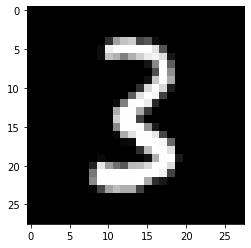

In [92]:
plt.imshow(xb[0].view(28, 28))
yb[0]

In [93]:
model, opt = get_model()

In [94]:
def fit():
    for epoch in range(epochs):
        for xb, yb in train_dl:
            pred = model(xb)
            loss = loss_func(pred, yb)
            loss.backward()
            opt.step()
            opt.zero_grad()

In [95]:
fit()

In [96]:
loss, acc = loss_func(model(xb), yb), accuracy(model(xb), yb)
assert acc > 0.7
loss, acc

(tensor(0.1895, grad_fn=<NllLossBackward>), tensor(0.9219))

### Random sampling

We want our training set to be in a random order, and that order should differ each iteration. But the validation set shouldn't be randomized.

In [97]:
class Sampler:
    def __init__(self, ds, bs, shuffle=False):
        self.n, self.bs, self.shuffle = len(ds), bs, shuffle

    def __iter__(self):
        self.idxs = torch.randperm(self.n) if self.shuffle else torch.arange(self.n)
        for i in range(0, self.n, self.bs):
            yield self.idxs[i : i + self.bs]

In [98]:
small_ds = Dataset(*train_ds[:10])

In [99]:
s = Sampler(small_ds, 3, False)
[o for o in s]

[tensor([0, 1, 2]), tensor([3, 4, 5]), tensor([6, 7, 8]), tensor([9])]

In [100]:
s = Sampler(small_ds, 3, True)
[o for o in s]

[tensor([4, 2, 6]), tensor([9, 5, 8]), tensor([0, 3, 7]), tensor([1])]

In [101]:
def collate(b):
    """Combines all xs into one vector and all ys into one vector."""
    xs, ys = zip(*b)
    return torch.stack(xs), torch.stack(ys)


class DataLoader:
    def __init__(self, ds, sampler, collate_fn=collate):
        self.ds, self.sampler, self.collate_fn = ds, sampler, collate_fn

    def __iter__(self):
        for s in self.sampler:
            yield self.collate_fn([self.ds[i] for i in s])

In [103]:
train_samp = Sampler(train_ds, bs, shuffle=True)
valid_samp = Sampler(valid_ds, bs, shuffle=False)

In [104]:
train_dl = DataLoader(train_ds, sampler=train_samp, collate_fn=collate)
valid_dl = DataLoader(valid_ds, sampler=valid_samp, collate_fn=collate)

tensor(3)

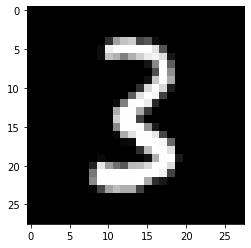

In [105]:
xb, yb = next(iter(valid_dl))
plt.imshow(xb[0].view(28, 28))
yb[0]

tensor(8)

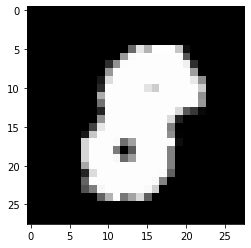

In [106]:
xb, yb = next(iter(train_dl))
plt.imshow(xb[0].view(28, 28))
yb[0]

tensor(8)

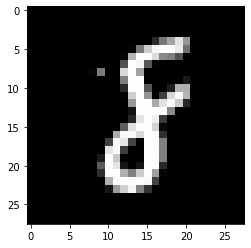

In [107]:
xb, yb = next(iter(train_dl))
plt.imshow(xb[0].view(28, 28))
yb[0]

In [108]:
model, opt = get_model()
fit()

loss, acc = loss_func(model(xb), yb), accuracy(model(xb), yb)
assert acc > 0.7
loss, acc

(tensor(0.0318, grad_fn=<NllLossBackward>), tensor(1.))

### PyTorch DataLoader

- `SequentialSampler` is when shuffle is False
- `RandomSampler` is when shuffle is True

In [109]:
from torch.utils.data import DataLoader, Dataset

In [110]:
train_dl = DataLoader(train_ds, bs, sampler=RandomSampler(train_ds), collate_fn=collate)
valid_dl = DataLoader(
    valid_ds, bs, sampler=SequentialSampler(valid_ds), collate_fn=collate
)

In [111]:
model, opt = get_model()
fit()
loss_func(model(xb), yb), accuracy(model(xb), yb)

(tensor(0.1394, grad_fn=<NllLossBackward>), tensor(0.9531))

PyTorch's defaults work fine for most things however:

In [112]:
train_dl = DataLoader(train_ds, bs, shuffle=True, drop_last=True)
valid_dl = DataLoader(valid_ds, bs, shuffle=False)

In [114]:
model, opt = get_model()
fit()

loss, acc = loss_func(model(xb), yb), accuracy(model(xb), yb)
assert acc > 0.7
loss, acc

(tensor(0.0801, grad_fn=<NllLossBackward>), tensor(0.9688))

Note that PyTorch's `DataLoader`, if you pass `num_workers`, will use multiple threads to call your `Dataset`.

# Validation

You **always** should also have a [validation set](http://www.fast.ai/2017/11/13/validation-sets/), in order to identify if you are overfitting.

We will calculate and print the validation loss at the end of each epoch.

(Note that we always call `model.train()` before training, and `model.eval()` before inference, because these are used by layers such as `nn.BatchNorm2d` and `nn.Dropout` to ensure appropriate behaviour for these different phases.)

In [115]:
def fit(epochs, model, loss_func, opt, train_dl, valid_dl):
    for epoch in range(epochs):
        # Handle batchnorm / dropout
        model.train()
        #         print(model.training)
        for xb, yb in train_dl:
            loss = loss_func(model(xb), yb)
            loss.backward()
            opt.step()
            opt.zero_grad()

        model.eval()
        #         print(model.training)
        with torch.no_grad():
            tot_loss, tot_acc = 0.0, 0.0
            for xb, yb in valid_dl:
                pred = model(xb)
                tot_loss += loss_func(pred, yb)
                tot_acc += accuracy(pred, yb)
        nv = len(valid_dl)
        print(epoch, tot_loss / nv, tot_acc / nv)
    return tot_loss / nv, tot_acc / nv

*Question*: Are these validation results correct if batch size varies?

`get_dls` returns dataloaders for the training and validation sets:

- We have twice as many batches for validation set since there is no backward pass and no storing of gradients.
- Also, there is no need to shuffle validation set since we are just computing the loss/accuracy and no training is happening.

In [116]:
# export
def get_dls(train_ds, valid_ds, bs, **kwargs):
    return (
        DataLoader(train_ds, batch_size=bs, shuffle=True, **kwargs),
        DataLoader(valid_ds, batch_size=bs * 2, **kwargs),
    )

Now, our whole process of obtaining the data loaders and fitting the model can be run in 3 lines of code:

In [117]:
train_dl, valid_dl = get_dls(train_ds, valid_ds, bs)
model, opt = get_model()
loss, acc = fit(5, model, loss_func, opt, train_dl, valid_dl)

0 tensor(0.1499) tensor(0.9565)
1 tensor(0.1335) tensor(0.9606)
2 tensor(0.2365) tensor(0.9337)
3 tensor(0.1773) tensor(0.9474)
4 tensor(0.1199) tensor(0.9664)


In [118]:
assert acc > 0.9

# Export

In [122]:
!python ../src/notebook2script.py 03_Minibatch_Training-Imad.ipynb

Converted 03_Minibatch_Training-Imad.ipynb to exp/nb_03.py
